<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Modeling Walkthrough

_Authors: Riley Dallas (AUS)_

---

### Learning Objectives
*After this lesson, you will be able to:*

- Gather, clean, explore and model a dataset from scratch.
- Split data into testing and training sets using both train/test split and cross-validation and apply both techniques to score a model.
- Evaluate several models.


## Importing libaries
---

We'll need the following libraries for today's lesson:

1. `pandas`
2. `numpy`
3. `seaborn`
4. `matplotlib.pyplot`
4. `train_test_split` and `cross_val_score` from `sklearn`'s `model_selection` module
5. `LinearRegression`, `LassoCV` and `RidgeCV` from `sklearn`'s `linear_model` module
6. `StandardScaler` from `sklearn`'s `preprocessing` module
7. `r2_score` from `sklearn`'s `metrics` module 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

%matplotlib inline

## Load the Data

---

Today's [dataset](http://www-bcf.usc.edu/~gareth/ISL/data.html) (`College.csv`) is from the [ISLR website](http://www-bcf.usc.edu/~gareth/ISL/). 

Rename `Unnamed: 0` to `University`.

In [2]:
df = pd.read_csv('../datasets/College.csv')
df.rename(columns={'Unnamed: 0': 'University'}, inplace=True)
df.head()

,University,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


## Data cleaning: Initial check
---

Check the following in the cells below:
1. Do we have any null values?
2. Are any numerical columns being read in as `object`?

In [3]:
# Check for nulls
df.isnull().sum()

University     0
Private        0
Apps           0
Accept         0
Enroll         0
Top10perc      0
Top25perc      0
F.Undergrad    0
P.Undergrad    0
Outstate       0
Room.Board     0
Books          0
Personal       0
PhD            0
Terminal       0
S.F.Ratio      0
perc.alumni    0
Expend         0
Grad.Rate      0
dtype: int64

In [4]:
# Check column data types
df.dtypes

University      object
Private         object
Apps             int64
Accept           int64
Enroll           int64
Top10perc        int64
Top25perc        int64
F.Undergrad      int64
P.Undergrad      int64
Outstate         int64
Room.Board       int64
Books            int64
Personal         int64
PhD             object
Terminal         int64
S.F.Ratio      float64
perc.alumni      int64
Expend           int64
Grad.Rate        int64
dtype: object

## Data cleaning: Clean up `PhD` column
---

`PhD` is being read in as a string because some of the cells contain non-numerical values. In the cell below, replace any non-numerical values with `NaN`'s, and change the column datatype to float.

In [4]:
df.PhD = df.PhD.map(lambda phd: np.nan if phd == '?' else float(phd))

In [5]:
df.dtypes

University      object
Private         object
Apps             int64
Accept           int64
Enroll           int64
Top10perc        int64
Top25perc        int64
F.Undergrad      int64
P.Undergrad      int64
Outstate         int64
Room.Board       int64
Books            int64
Personal         int64
PhD            float64
Terminal         int64
S.F.Ratio      float64
perc.alumni      int64
Expend           int64
Grad.Rate        int64
dtype: object

In [6]:
df.isnull().sum()

University      0
Private         0
Apps            0
Accept          0
Enroll          0
Top10perc       0
Top25perc       0
F.Undergrad     0
P.Undergrad     0
Outstate        0
Room.Board      0
Books           0
Personal        0
PhD            29
Terminal        0
S.F.Ratio       0
perc.alumni     0
Expend          0
Grad.Rate       0
dtype: int64

## Data cleaning: Drop `NaN`'s
---

Since there are a small percentage of null cells, let's go ahead and drop them.

In [7]:
df.shape

(777, 19)

In [8]:
df.dropna(inplace=True)

In [9]:
df.shape

(748, 19)

## Feature engineering: Binarize `'Private'` column
---

In the cells below, convert the `Private` column into numerical values.

In [10]:
df['Private'].value_counts()

Yes    544
No     204
Name: Private, dtype: int64

In [11]:
df['Private'] = df['Private'].map({'Yes': 1, 'No': 0})

## Feature engineering: Create an `Elite` column
---

The `Top10perc` is the percentage of students enrolled that graduated high school in the top 10th percentile. Let's create a column called `Elite` that has the following values:
- 1 if `Top10perc` is greater than or equal to 50%
- 0 if `Top10perc` is less than 50%

In [12]:
df['Elite'] = (df.Top10perc > 50).astype(int)

## EDA: Plot a Heatmap of the Correlation Matrix
---

Heatmaps are an effective way to visually examine the correlational structure of your predictors. 

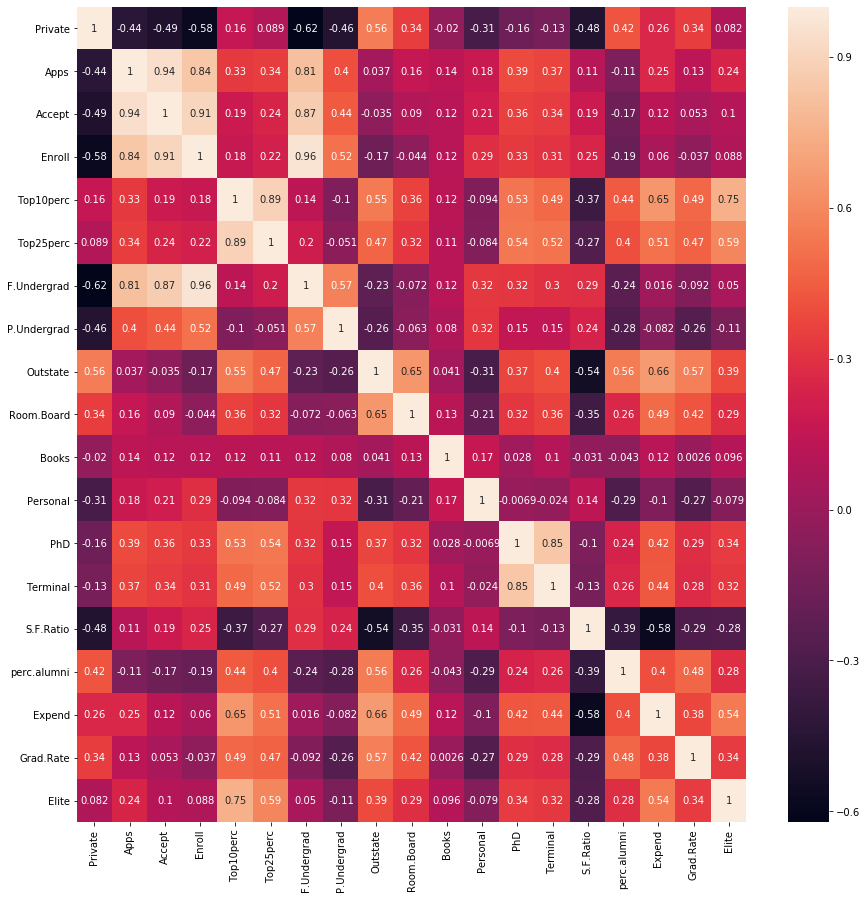

In [13]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True)

## EDA: Use seaborn's `.pairplot()` method to create scatterplots 
---

Let's create a pairplot to see how some of our stronger predictors correlate to our target (`Apps`). Instead of creating a pairplot of the entire DataFrame, we can use the `y_vars` and `x_vars` params to get a smaller subset.

In [15]:
df.corr()['Apps'].sort_values()

Private       -0.441434
perc.alumni   -0.105778
Outstate       0.036517
S.F.Ratio      0.109378
Grad.Rate      0.129846
Books          0.138333
Room.Board     0.162503
Personal       0.182639
Elite          0.242110
Expend         0.252854
Top10perc      0.330712
Top25perc      0.344498
Terminal       0.368173
PhD            0.389312
P.Undergrad    0.400406
F.Undergrad    0.811162
Enroll         0.842801
Accept         0.943316
Apps           1.000000
Name: Apps, dtype: float64

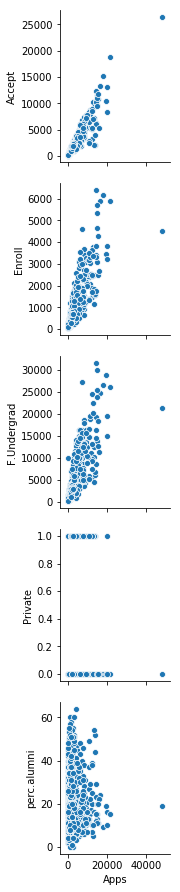

In [16]:
sns.pairplot(df, y_vars=['Accept', 'Enroll', 'F.Undergrad', 'Private', 'perc.alumni'], x_vars=['Apps'])

## EDA: Create histograms of all numerical columns
---

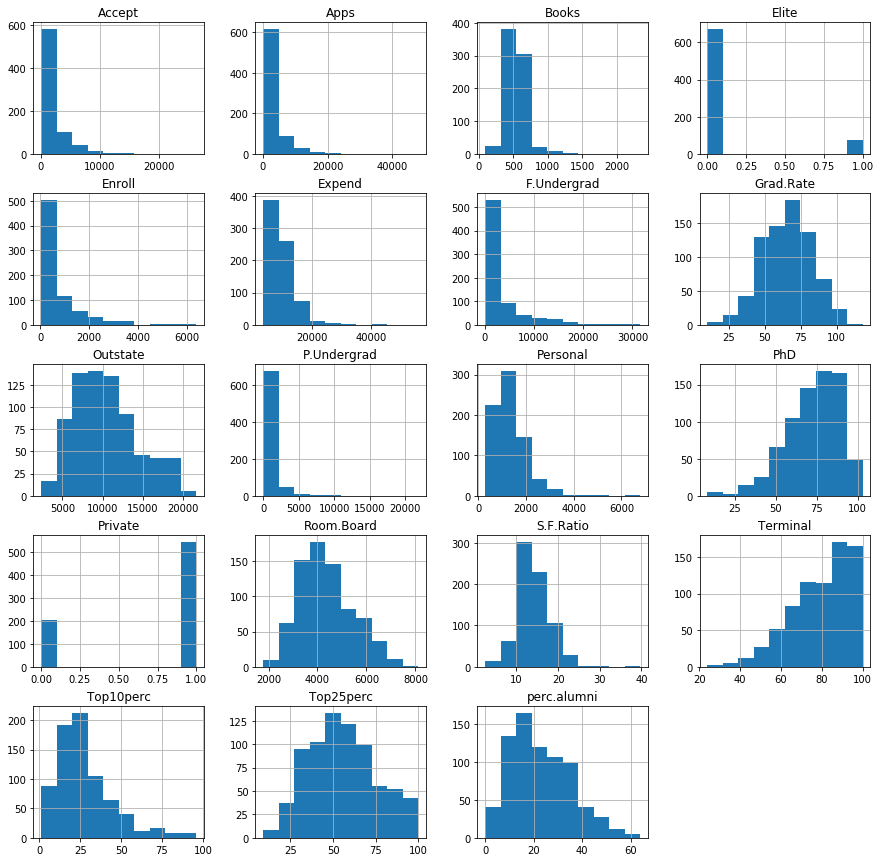

In [17]:
df.hist(figsize=(15, 15));

## EDA: Boxplots
---

In the cells below, create two boxplots:
1. One for our taget (`Apps`)
2. And one for our strongest predictor (`Accept`)

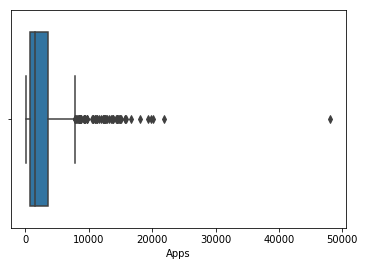

In [18]:
sns.boxplot(df['Apps'])

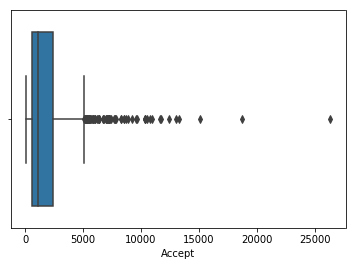

In [19]:
sns.boxplot(df['Accept'])

## Model Prep: Create our features matrix (`X`) and target vector (`y`)
---

Every **numerical** column (that is not our target) will be used as a feature.

The `Apps` column is our label: the number of applications received by that university.

In the cell below, create your `X` and `y` variables.

In [14]:
features = [col for col in df._get_numeric_data().columns if col != 'Apps']
X = df[features]
y = df['Apps']

## Model Prep: Train/test split
---

We always want to have a holdout set to test our model. Use the `train_test_split` function to split our `X` and `y` variables into a training set and a holdout set.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Model Prep: Scaling
---

Since we're using `Lasso` and `Ridge`, we'll want to scale our features. In the cell below, fit a `StandardScaler` to `X_train` and use it to transform both `X_train` and `X_test`.

In [16]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

## Model Prep: Instantiate our models
---

We'll be evaluating `LinearRegression`, `LassoCV` and `RidgeCV`, so we'll need to create instances of all three models.

In [17]:
lr = LinearRegression()

In [18]:
lasso = LassoCV(n_alphas=200)

In [19]:
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

## Cross validation
---

Use `cross_val_score` to evaluate all three models.

In [20]:
lr_scores = cross_val_score(lr, X_train, y_train, cv=3)
lr_scores.mean()

0.9108035981211181

In [21]:
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=3)
lasso_scores.mean()

/Users/gateam/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/gateam/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/gateam/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.9132778607645747

In [22]:
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=3)
ridge_scores.mean()

0.9104274277897381

## Model Fitting and Evaluation
---

`RidgeCV` seems to be doing the best, so let's move forward with that model. Fit the model to the training data, and evaluate the training and test scores below.

In [23]:
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,
        1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,
        2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,
        3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,
        4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,  5.5,
        5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,  6.6,
        6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,  7.7,
        7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,  8.8,
        8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,  9.9,
       10. ]),
        cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
        scoring=None, store_cv_values=False)

In [24]:
ridge.score(X_train, y_train)

0.9241079135562579

In [31]:
ridge.score(X_test, y_test)

0.9084063233364035

In [32]:
ridge_scores.mean()

0.9104274277897381

In [33]:
pred = ridge.predict(X_test)

In [34]:
r2_score(y_test, pred)

0.9084063233364035

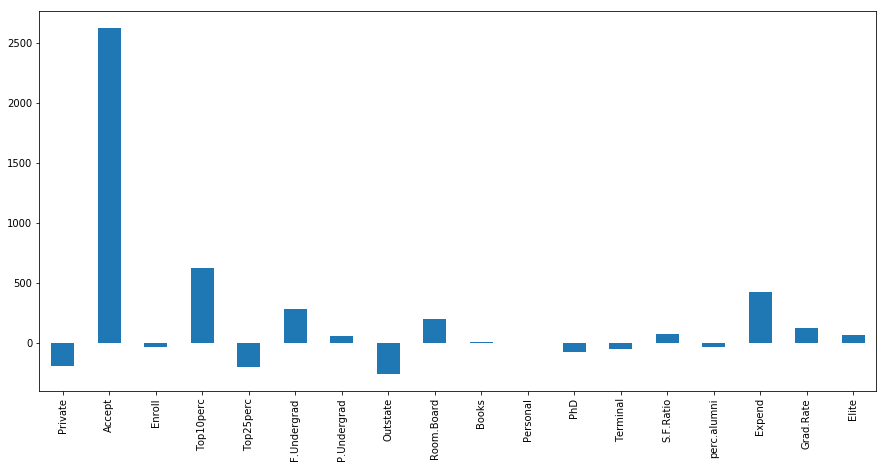

In [35]:
pd.Series(ridge.coef_, index=features).plot.bar(figsize=(15, 7))

In [36]:
residuals = y_test - pred

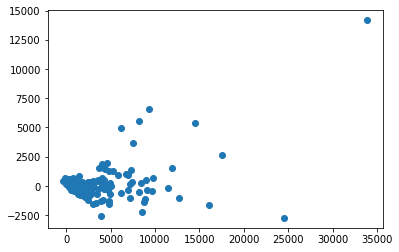

In [37]:
plt.scatter(pred, residuals)